Import delle librerie e altri comandi di configurazione

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import re
import os

sns.set(style='whitegrid', font_scale=1.2)

%matplotlib inline

Import dataset

In [2]:
bbt_eps = pd.read_csv('big_bang_theory_episodes.csv')
bbt_imd = pd.read_csv('big_bang_theory_imdb.csv')

Tidy

Sistemazione bbt_imd

In [3]:
# In bbt_imd, le date sono nel formato '%d %b\.? %Y', con o senza il punto. Uniformo le date in modo che siano tutte nello stesso formato,
# per poi creare oggetti datetime per esse. Dopodiché divido la data in anno, mese, giorno (potrebbe essere utile per dopo)
bbt_imd.replace({'original_air_date': '\\.'}, {'original_air_date': ''}, regex=True, inplace=True)
bbt_imd['original_air_date'] = pd.to_datetime(bbt_imd['original_air_date'], format='%d %b %Y', dayfirst=True)
bbt_imd['year'] = bbt_imd['original_air_date'].transform(lambda y: y.year)
bbt_imd['month'] = bbt_imd['original_air_date'].transform(lambda m: m.month)
bbt_imd['day'] = bbt_imd['original_air_date'].transform(lambda d: d.day)
bbt_imd.drop('original_air_date', axis='columns', inplace=True)

# Riordino le colonne
bbt_imd = bbt_imd[['season', 'episode_num', 'title', 'year', 'month', 'day', 'imdb_rating', 'total_votes', 'desc']]

# Assegnazione tipi corretti e rinomina colonne
bbt_imd = bbt_imd.astype({'title': 'string', 'desc': 'string'})
bbt_imd.rename(columns={'season': 'Stagione',
                        'episode_num': 'Episodio nella stagione',
                        'title': 'Titolo',
                        'year': 'Anno',
                        'month': 'Mese',
                        'day': 'Giorno',
                        'imdb_rating': 'Valutazione IMDb (scala 1-10)',
                        'total_votes': 'Voti totali',
                        'desc': 'Trama dell\'episodio'}, inplace=True)

Sistemazione bbt_eps

In [4]:
# Assegnazione tipi corretti
bbt_eps = bbt_eps.astype({'title': 'string', 'directed_by': 'string', 'written_by': 'string', 'prod_code': 'string'})

# Procedimento simile a bbt_imd
bbt_eps['original_air_date'] = pd.to_datetime(bbt_eps['original_air_date'], yearfirst=True)
bbt_eps['year'] = bbt_eps['original_air_date'].transform(func=lambda x: x.year)
bbt_eps['month'] = bbt_eps['original_air_date'].transform(func=lambda x: x.month)
bbt_eps['day'] = bbt_eps['original_air_date'].transform(func=lambda x: x.day)
bbt_eps.drop('original_air_date', axis='columns', inplace=True)

# Riordino le colonne
bbt_eps = bbt_eps[['prod_code', 'season', 'episode_num_in_season', 'episode_num_overall', 'title', 'directed_by', 'written_by', 'year', 'month', 'day', 'us_viewers']]

# Cambiamento di scala in modo che le visualizzazioni siano per milione
bbt_eps = bbt_eps.round({'us_viewers': 0})
bbt_eps['us_viewers'] *= 10e-6

# La colonna 'written_by' contiene dentro di sé due una lista di nomi, divisa in 'Story by:' e 'Teleplay by:'. La colonna viene divisa in due colonne,
# e messe in due DataFrame differenti per comodità
writers = [[t.strip().split('Story by:') for t in u] for u in [s.split('Teleplay by:') for s in bbt_eps['written_by']]]
story_writers = [[s.strip() for s in t[0] if s != ''] for t in writers]
teleplay_writers = []
for r in writers:
    if len(r) == 1:
        teleplay_writers.append(r[0])
    else:
        teleplay_writers.append(r[1])

def split_names(llst):
    llst = [[re.split('&|,', s) for s in t] for t in llst]
    llst = [[[s.strip() for s in t] for t in u] for u in llst]
    llst = [s[0] for s in llst]
    return llst

story_writers = split_names(story_writers)

# Gestione di un caso particolare (David Saltzberg & Ph.D)
for names in story_writers:
    if 'David Saltzberg' in names and 'Ph.D' in names:
        i = names.index('Ph.D')
        del names[i]
        break

teleplay_writers = split_names(teleplay_writers)

bbt_stry_wrts = pd.DataFrame(columns=['prod_code', 'story_by'])
bbt_tlpy_wrts = pd.DataFrame(columns=['prod_code', 'teleplay_by'])

def add_rows(df, llst):
    for i, p in enumerate(bbt_eps['prod_code']):
        n = len(llst[i])
        for j in range(0,n):
            df.loc[len(df)] = (p, llst[i][j])
    return df

bbt_stry_wrts = add_rows(bbt_stry_wrts, story_writers)
bbt_tlpy_wrts = add_rows(bbt_tlpy_wrts, teleplay_writers)

# Correzione errori di ortografia e uniformazione dei nomi
def fix_names(col):
    if col == 'story_by':
        bbt_stry_wrts.loc[bbt_stry_wrts[col] == 'Billy Prady', col] = 'Bill Prady'
        bbt_stry_wrts.loc[bbt_stry_wrts[col] == 'Erik Kaplan', col] = 'Eric Kaplan'
        bbt_stry_wrts.loc[bbt_stry_wrts[col] == 'Nicole Lorre', col] = 'Nikki Lorre'
        bbt_stry_wrts.loc[bbt_stry_wrts[col] == 'Saladin Patterson', col] = 'Saladin K. Patterson'
        return bbt_stry_wrts
    elif col == 'teleplay_by':
        bbt_tlpy_wrts.loc[bbt_tlpy_wrts[col] == 'Jermey Howe', col] = 'Jeremy Howe'
        bbt_tlpy_wrts.loc[bbt_tlpy_wrts[col] == 'Tara Hernadnez', col] = 'Tara Hernandez'
        bbt_tlpy_wrts.loc[bbt_tlpy_wrts[col] == 'Dave Steve Holland', col] = 'Steve Holland'
        return bbt_tlpy_wrts

bbt_stry_wrts = fix_names('story_by')
bbt_tlpy_wrts = fix_names('teleplay_by')

bbt_eps.drop('written_by', axis='columns', inplace=True)
bbt_eps.set_index('prod_code', inplace=True)

# Rinomina colonne e indice
bbt_eps.rename(columns={'season': 'Stagione',
                'episode_num_in_season': 'Episodio nella stagione',
                'episode_num_overall': 'Episodio complessivo',
                'title': 'Titolo',
                'directed_by': 'Regista',
                'year': 'Anno',
                'month': 'Mese',
                'day': 'Giorno',
                'us_viewers': 'Spettatori USA (milioni)'}, inplace=True)
bbt_eps.rename_axis(index={'prod_code': 'Codice di produzione'}, inplace=True)
bbt_stry_wrts.rename(columns={'prod_code': 'Codice di produzione', 'story_by': 'Soggettista'}, inplace=True)
bbt_tlpy_wrts.rename(columns={'prod_code': 'Codice di produzione', 'teleplay_by': 'Sceneggiatore'}, inplace=True)

# **Fondamenti di Scienza dei Dati e Laboratorio**
**Il dataset _The Big Bang Theory_**
<div align="center">
    <img src="https://upload.wikimedia.org/wikipedia/commons/1/13/TBBT_logo.svg" width="250">
</div>

# Introduzione
Questa presentazione volgerà sullo studio di due dataset su *The Big Bang Theory*, una sitcom statunitense del 2007 ideata da *Chuck Lorre* e *Bill Prady*.
## Perché?
- Conosco molto bene la serie
- Semplice trovare dataset online
- Mi sono posto domande che reputavo interessanti

## Domande:
1. Qual è l'episodio più visto? E quello meno visto?
2. Qual è l'episodio piaciuto di più? E quello piaciuto di meno?
3. La serie ha avuto un calo di ascolti negli anni? Quali sono le stagioni più viste e meno viste?
4. La serie ha avuto un calo delle votazioni negli anni? Quali sono le stagioni più piaciute e meno piaciute?

# Dataset utilizzati
Ho utilizzato due dataset, chiamati *big_bang_theory_episodes.csv* e *big_bang_theory_imdb.csv*, che contengono informazioni sugli episodi e sulle loro valutazioni.

I dataset sono stati creati da *Bill Cruise* nel 2022 e sono disponibili su Kaggle:

[https://www.kaggle.com/datasets/bcruise/big-bang-theory-episodes]()

## Dati:
**big_bang_theory_episodes:**
- Stagione
- Numero episodio nella stagione
- Numero Numero episodi
- Titolo
- Regista
- Scrittori (soggettista e sceneggiatore)
- Data prima trasmissione
- Milioni di spettatori statunitensi

**big_bang_theory_imdb:**
- Stagione
- Numero episodio nella stagione
- Titolo
- Data prima trasmissione
- Valutazione IMDb (scala 1-10)
- Voti totali
- Trama dell'episodio

# Risposte
## 1. Qual è l'episodio più visto? E quello meno visto? 
Unendo i due dataset e aggregando rispettivamente per il massimo e il minimo numero di spettatori, sono riuscito a trovare che:

- **Episodio più visto:** L'episodio **07x02** *The Deception Verification*, con **204.4** milioni di spettatori negli Stati Uniti.

- **Episodio meno visto:** L'episodio **01x17** *The Tangerine Factor*, con **73.4** milioni di spettatori negli Stati Uniti (l'ultimo episodio della prima stagione).

In [5]:
eps_ratings = bbt_eps.merge(bbt_imd, on='Titolo', suffixes=('', '_y'))[list(bbt_eps.columns) + ['Valutazione IMDb (scala 1-10)', 'Voti totali', 'Trama dell\'episodio']]

In [6]:
most_viewed_ep = eps_ratings.loc[eps_ratings['Spettatori USA (milioni)'].argmax()]
most_viewed_ep

Stagione                                                                         7
Episodio nella stagione                                                          2
Episodio complessivo                                                           137
Titolo                                                  The Deception Verification
Regista                                                            Mark Cendrowski
Anno                                                                          2013
Mese                                                                             9
Giorno                                                                          26
Spettatori USA (milioni)                                                     204.4
Valutazione IMDb (scala 1-10)                                                  8.0
Voti totali                                                                   3374
Trama dell'episodio              Sheldon feels betrayed when Leonard returns fr...
Name

In [7]:
least_viewed_ep = eps_ratings.loc[eps_ratings['Spettatori USA (milioni)'].argmin()]
least_viewed_ep

Stagione                                                                         1
Episodio nella stagione                                                         17
Episodio complessivo                                                            17
Titolo                                                        The Tangerine Factor
Regista                                                            Mark Cendrowski
Anno                                                                          2008
Mese                                                                             5
Giorno                                                                          19
Spettatori USA (milioni)                                                      73.4
Valutazione IMDb (scala 1-10)                                                  8.5
Voti totali                                                                   4101
Trama dell'episodio              After a bad breakup, Penny finally agrees to g...
Name

## 2. Qual è l'episodio piaciuto di più? E quello piaciuto di meno?
Lavoro simile alla prima domanda, eccetto che calcolo il massimo e minimo delle valutazioni. Si può trovare che:

- **Valutazione più alta:** L'episodio **12x24** *The Stockholm Syndrome* con valutazione **9.5/10** (l'ultimo episodio dell'ultima stagione).

- **Valutazione più bassa:** Parità tra:
  - L'episodio **09x01** *The Matrimonial Momentum*
  - L'episodio **10x22** *The Cognition Regeneration*
  - L'episodio **11x17** *The Athenaeum Allocation*
  - L'episodio **12x05** *The Planetarium Collision*

Tutti con valutazione **6.8/10**.

In [8]:
most_liked_ep = eps_ratings.loc[eps_ratings['Valutazione IMDb (scala 1-10)'].argmax()]
most_liked_ep

Stagione                                                                        12
Episodio nella stagione                                                         24
Episodio complessivo                                                           279
Titolo                                                      The Stockholm Syndrome
Regista                                                            Mark Cendrowski
Anno                                                                          2019
Mese                                                                             5
Giorno                                                                          16
Spettatori USA (milioni)                                                     185.2
Valutazione IMDb (scala 1-10)                                                  9.5
Voti totali                                                                   8791
Trama dell'episodio              Bernadette and Wolowitz leave their kids for t...
Name

In [9]:
least_liked_ep = eps_ratings.loc[eps_ratings['Valutazione IMDb (scala 1-10)'] == eps_ratings['Valutazione IMDb (scala 1-10)'].min()]
least_liked_ep

,Stagione,Episodio nella stagione,Episodio complessivo,Titolo,Regista,Anno,Mese,Giorno,Spettatori USA (milioni),Valutazione IMDb (scala 1-10),Voti totali,Trama dell'episodio
183,9,1,184,The Matrimonial Momentum,Mark Cendrowski,2015,9,21,182.0,6.8,3331,Penny struggles with Leonard's confession that...
228,10,22,229,The Cognition Regeneration,Mark Cendrowski,2017,4,27,145.2,6.8,2042,Leonard is less than thrilled when Penny consi...
247,11,17,248,The Athenaeum Allocation,Mark Cendrowski,2018,3,8,138.8,6.8,1957,Leonard jumps through hoops to help secure the...
259,12,5,260,The Planetarium Collision,Mark Cendrowski,2018,10,18,122.2,6.8,2021,Amy doesn't have time to work with Sheldon on ...


## 3. La serie ha avuto un calo di ascolti negli anni? Quali sono le stagioni più viste e meno viste?
- La serie ha un andamento **parabolico** di ascolti, con incremento nelle prime sei stagioni, picco tra la settima e nona stagione, e calo degli ascolti dalla nona stagione in poi
- Le stagioni più viste sono la **settima** e la **nona**
- Quella meno vista la **prima**
- Dalla seconda alla terza stagione c'è stato un incremento di ascolti del **28.84%**
- Dalla decima alla undicesima stagione c'è stato un calo significativo, del **17.02%**

![](src\spettatori_usa_stagione.png)

In [10]:
medians_views = eps_ratings.groupby('Stagione')['Spettatori USA (milioni)'].median()
medians_views

Stagione
1      85.80
2      97.70
3     137.30
4     126.90
5     149.35
6     167.25
7     177.05
8     176.35
9     177.65
10    166.00
11    137.75
12    128.25
Name: Spettatori USA (milioni), dtype: float64

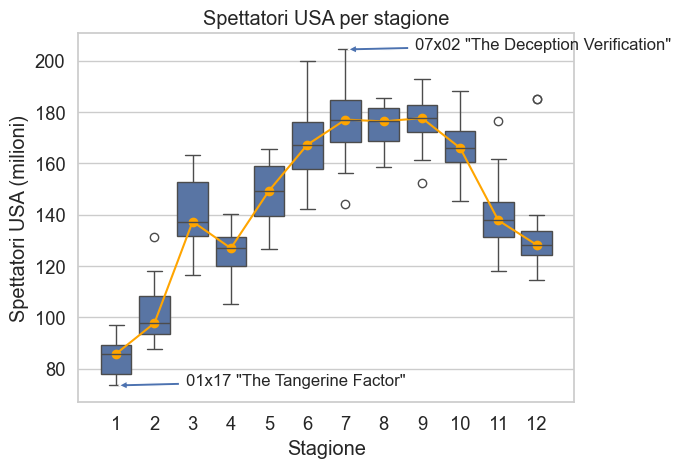

In [11]:
# Schema per annotare i dati nella forma SSxEP "Titolo"
def dict_ep_annotation(df, info, xytext):
    return {'text': f"{df['Stagione']:02d}x{df['Episodio nella stagione']:02d} \"{df['Titolo']}\"",
            'xy': df.loc[['Stagione', info]]-(1,0), # fix offset
            'xycoords': 'data',
            'xytext': xytext,
            'textcoords': 'offset points',
            'arrowprops': {'arrowstyle': 'simple'},
            'fontsize': 'small'
            }

ax = sns.boxplot(eps_ratings, x='Stagione', y='Spettatori USA (milioni)');
ax.set_title('Spettatori USA per stagione');
ax.annotate(**dict_ep_annotation(most_viewed_ep, 'Spettatori USA (milioni)', (50, 0)));
ax.annotate(**dict_ep_annotation(least_viewed_ep, 'Spettatori USA (milioni)', (50,0)));
x_coords = range(12)
ax.plot(x_coords, medians_views, marker='o', linestyle='-', color='orange');
plt.savefig(os.path.join('src', 'spettatori_usa_stagione.png'), bbox_inches='tight');

## 4. La serie ha avuto un calo delle votazioni negli anni? Quali sono le stagioni più piaciute e meno piaciute?
- **Sì**, con l'aumentare delle stagioni c'è stato un calo progressivo delle valutazioni
- La stagione più piaciuta è la **terza**, mentre le **ultime due** sono le meno piaciute
- Tra la settima e ottava stagione c'è stato un calo significativo delle valutazioni: del **4.46%**
![](src\valutazione_stagione.png)

### Cosa ha causato il calo delle valutazioni?
- Calcolando l'indice di correlazione di Pearson $\rho$, si è potuta trovare una forte correlazione positiva tra le valutazioni e il numero di voti totali.

![](src\corr_voti_val.png)

- D'altra parte, il numero di episodi e i voti totali sono in correlazione negativa.
- Questo vuol dire che dato che gli episodi aumentano, diminuiscono i voti totali, e quindi di conseguenza diminuiscono anche le valutazioni.

![](src\voti_ep.png)

In [12]:
medians_reviews = eps_ratings.groupby('Stagione')['Valutazione IMDb (scala 1-10)'].median()
medians_reviews

Stagione
1     8.20
2     8.20
3     8.30
4     8.10
5     8.00
6     8.00
7     7.85
8     7.50
9     7.40
10    7.30
11    7.20
12    7.20
Name: Valutazione IMDb (scala 1-10), dtype: float64

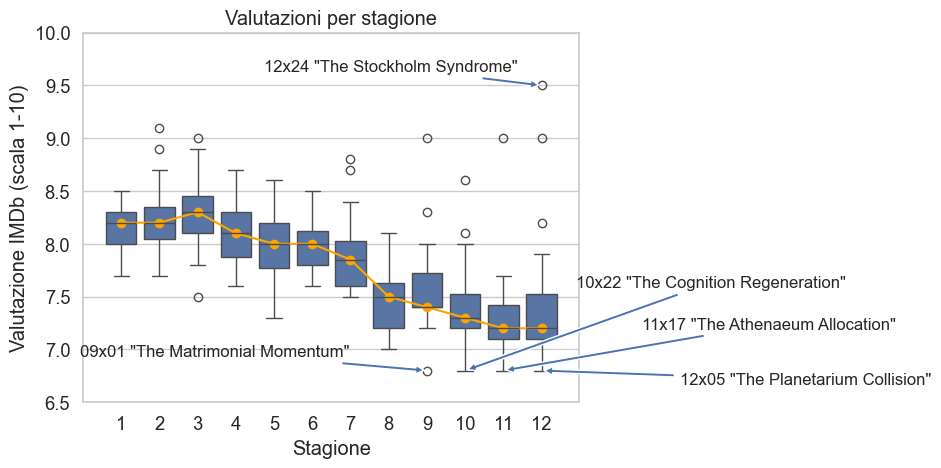

In [13]:
ax = sns.boxplot(eps_ratings, x='Stagione', y='Valutazione IMDb (scala 1-10)');
ax.set_ylim(6.5, 10);
ax.set_title('Valutazioni per stagione')
ax.annotate(**dict_ep_annotation(most_liked_ep, 'Valutazione IMDb (scala 1-10)', (-200,10)));

ARROW_POSITIONS = [(-250, 10), (80, 60), (100, 30), (100, -10)]
for i in range(0, len(least_liked_ep)):
    ax.annotate(**dict_ep_annotation(least_liked_ep.iloc[i], 'Valutazione IMDb (scala 1-10)', ARROW_POSITIONS[i]));
ax.plot(x_coords, medians_reviews, marker='o', linestyle='-', color='orange');
plt.savefig(os.path.join('src', 'valutazione_stagione.png'), bbox_inches='tight');

Cerchiamo possibili relazioni con un pair plot:

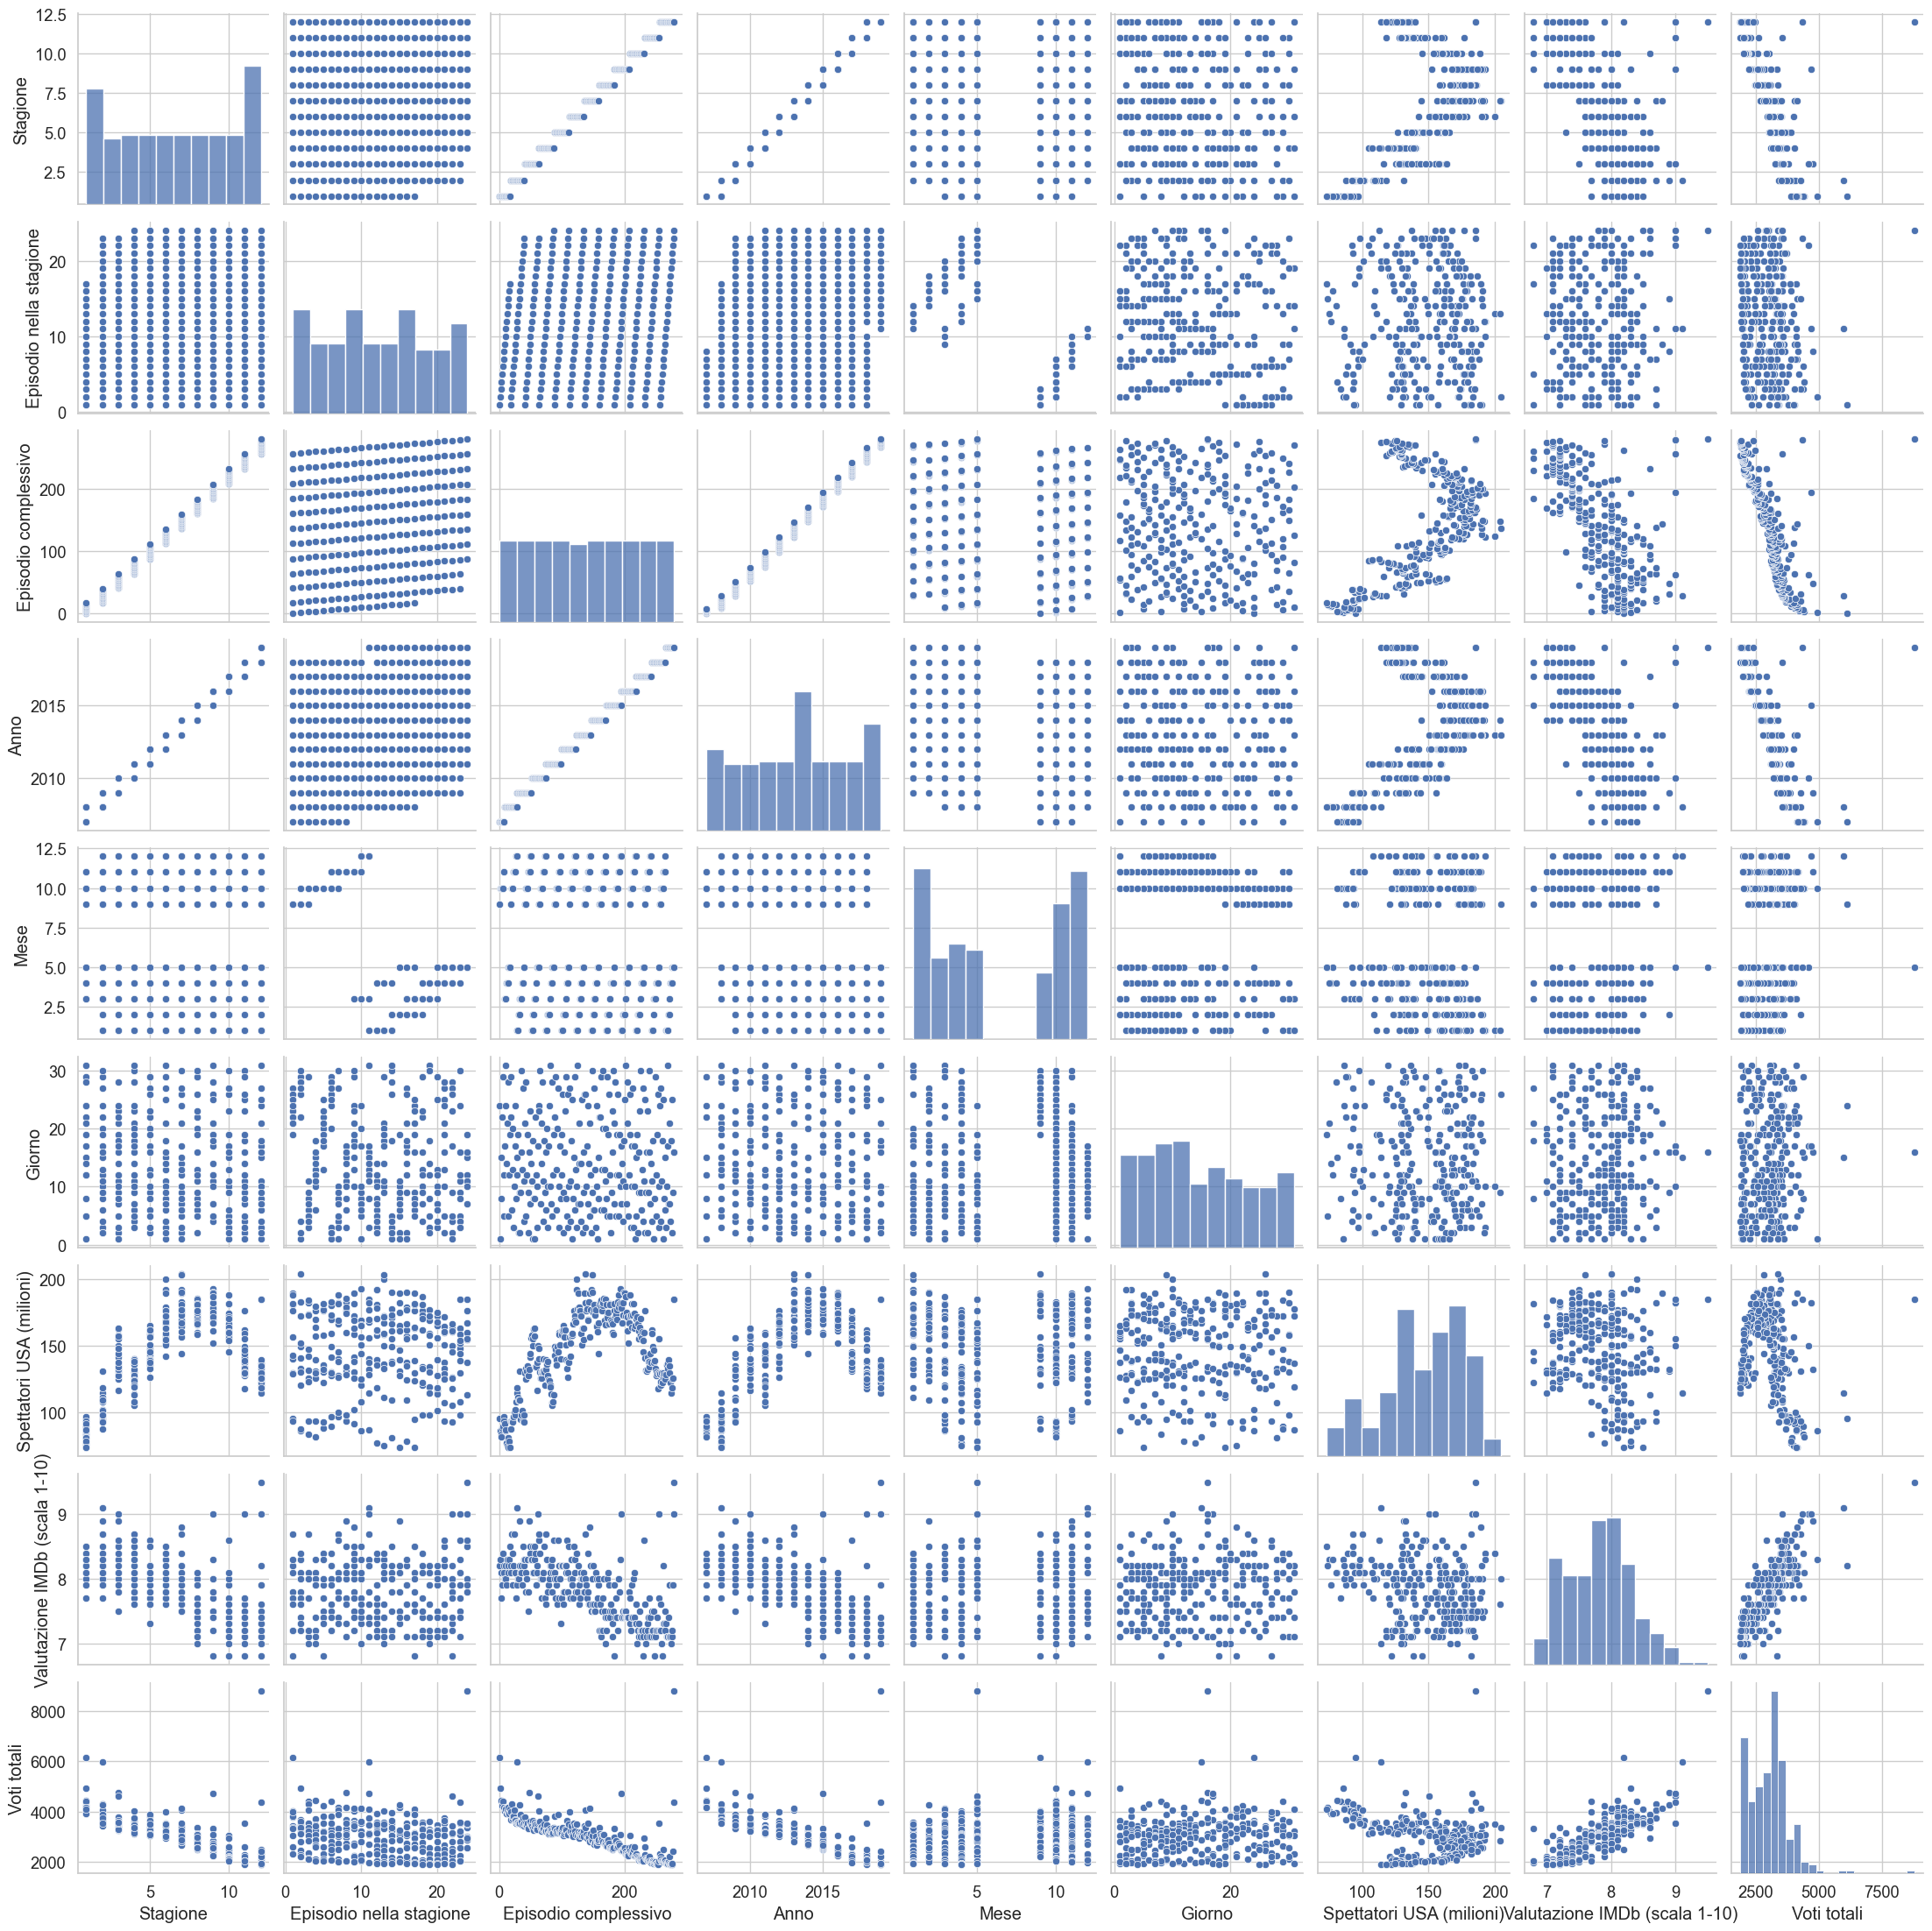

In [14]:
sns.pairplot(eps_ratings).tight_layout();

In [15]:
# Allo stesso tempo calcolo la correlazione di Pearson e faccio una regressione lineare sulle variabili specificate (evito duplicazione di codice)
def regplot_and_pearsonr(df, x, y, xy, ha, va, scatter=True):
    ax = sns.regplot(df, x=x, y=y, scatter_kws={'alpha': 0.5}, scatter=scatter);
    corr, p = pearsonr(df[x], df[y])
    ax.annotate(f'$\\rho$ = {corr:.3f}, p = {p:.3e}', xy=xy, xycoords='axes fraction', ha=ha, va=va);
    return ax, corr, p

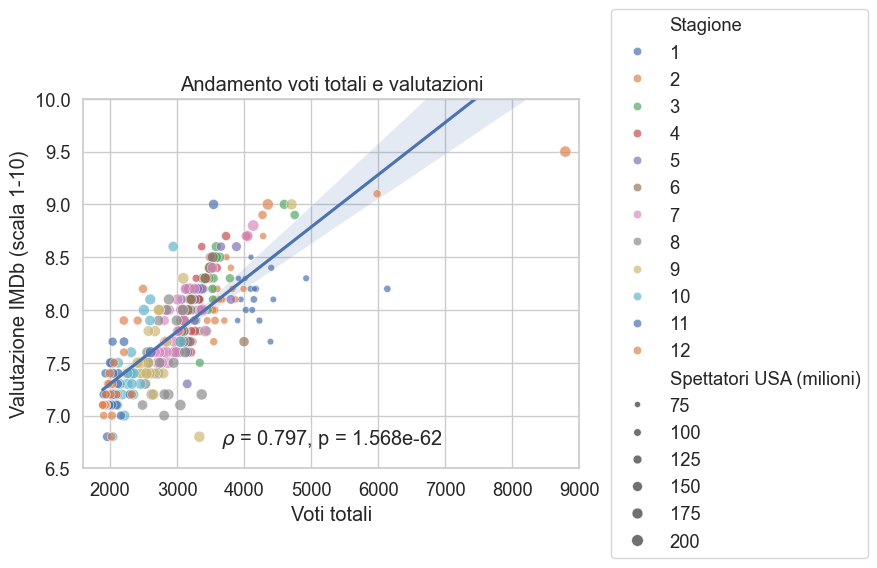

In [16]:
ax, corr, p = regplot_and_pearsonr(eps_ratings, 'Voti totali', 'Valutazione IMDb (scala 1-10)', (0.5, 0.05), 'center', 'bottom', scatter=False);
ax.set_ylim(6.5,10);
ax.set_xlim(1600, 9000);
ax.set_title('Andamento voti totali e valutazioni');
ax = sns.scatterplot(eps_ratings, x='Voti totali', y='Valutazione IMDb (scala 1-10)',
                     alpha=0.7, hue='Stagione', size='Spettatori USA (milioni)', palette=sns.color_palette(n_colors=12));
sns.move_legend(ax, loc='center right', bbox_to_anchor=(1.6,0.5));
plt.savefig(os.path.join('src', 'corr_voti_val.png'), bbox_inches='tight');

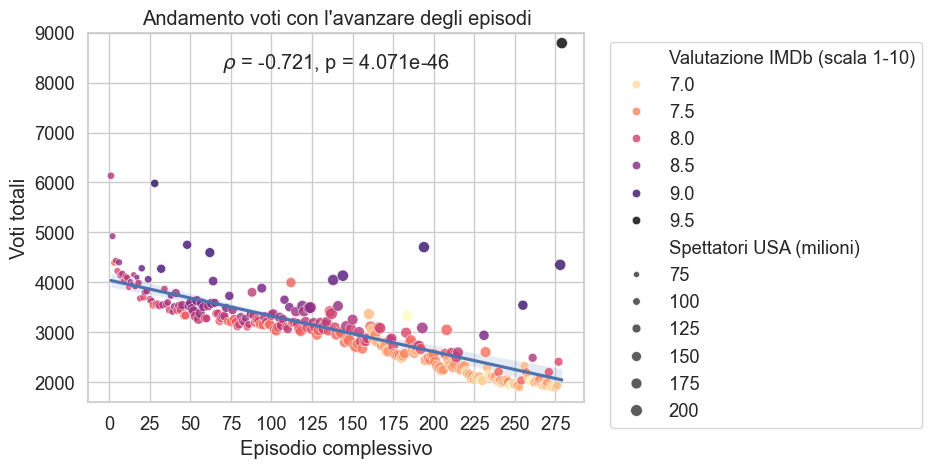

In [17]:
ax, corr, p = regplot_and_pearsonr(eps_ratings, 'Episodio complessivo', 'Voti totali', (0.5, 0.95), 'center', 'top', scatter=False);
ax = sns.scatterplot(eps_ratings, x='Episodio complessivo', y='Voti totali', hue='Valutazione IMDb (scala 1-10)',
                     palette='magma_r', size='Spettatori USA (milioni)', alpha=0.8);
sns.move_legend(ax, loc='upper right', bbox_to_anchor=(1, 1, 0.7, 0));
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(25));
ax.set_ylim(1600, 9000);
ax.set_title('Andamento voti con l\'avanzare degli episodi');
plt.savefig(os.path.join('src', 'voti_ep.png'), bbox_inches='tight');

In [18]:
def calculate_loss_percentage(df, n, m):
    return (((df[n] - df[m]) / df[n]))

print(f'{calculate_loss_percentage(medians_views, 10, 11) * 100: .2f}%')
print(f'{calculate_loss_percentage(medians_reviews, 7, 8) * 100: .2f}%')
print(f'{calculate_loss_percentage(medians_views, 3, 2) * 100: .2f}%')

 17.02%
 4.46%
 28.84%


# Conclusioni
- L'andamento del numero di spettatori per stagione ha andamento **parabolico**
- Le prime sei stagioni hanno valutazioni più alte ma hanno meno spettatori
- Dalla settima stagione fino alla nona c'è un picco nel numero di spettatori, ma valutazioni via via più basse
  - In particolare l'ottava stagione ha avuto un significativo calo di valutazioni rispetto alla settima: da **7.85/10** a **7.50/10** (di mediana)
    - Un calo del **4.46%**
- Le stagioni dalla nona alla dodicesima hanno le valutazioni più basse (con qualche caso eccezionale)
- Dopo la nona stagione si subisce un calo progressivo degli ascolti
  - Dalla decima alla undicesima stagione c'è stato un calo degli ascolti particolarmente significativo: da **166 milioni** a **137.75 milioni** (di mediana)
    - Un calo del **17.02%**
- Il calo delle valutazioni è dovuto dal calo di voti totali per episodio